In [ ]:
# default_exp plotting

In [ ]:
#hide 

from joblib import *
from nbdev.showdoc import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

# Plotting
> Utility plotting module designed to take SALA objects and provide relevant plotting tools
for sleep and light data.

Plots created within this module require particular information to be present within the data. Specifically, data related to sleep, light, or location are of importance for this dataset. Therefore, the plotting functions here take in dataframes like those found within SALA objects.

In [ ]:
class ClockPlot:
    """
    Clock-style plots for groupings within timing data. Requires specific information
    about light and location in order to properly render all portions of the plot. This
    information can be properly appended to a dataframe through the usage of the main
    SALA module. 
    
    
    Methods
    -------
    mins_to_radians(data)
        Maps a series of minutes to radians for plot making.
    print_time(mins)
        Takes in a time as a float and returns a printable format.
    plot(timing_data, group_by, thresholds=[], figsize=(5,10), timezone=None)
        Creates a clock-shaped plot for grouping with SALA-styled timing data.
    """
    
    @staticmethod
    def mins_to_radians(data):
        """Maps a series of minutes to radians for plot making.

        #### Parameters

        data: pd.Series
            A series of minute data

        #### Returns

        (as a tuple) list of mins converted to radians, a converted median
        """
        if type(data) != pd.Series:
            raise TypeError("Error: function expected a series as input")
        median = data.median()
        p25 = data.quantile(0.25)
        p75 = data.quantile(0.75)
        
        return ([x/1440.0*2*np.pi for x in np.arange(p25,p75)], median/1440.0*2*np.pi)
    
    @staticmethod
    def print_time(mins):
        """Takes a time (minutes) and returns a printable format.

        #### Parameters

        mins: float
            A numeric value representing minutes.

        #### Returns

        A printable format
        """
        h = int(mins / 60.)
        m = int ( (mins - h * 60) )
        if h >= 24.0:
            h -= 24
        return '{:02d}:{:02d}'.format(h,m)
    
    @staticmethod
    def plot(timing_data, group_by, thresholds = [], figsize = (5, 10), timezone = None):
        """Creates clock plots for a grouping within SALA-styled timing data. For
        full functionality, the data should have specifically labeled columns for
        'Sunrise', 'Sunset', 'Mins to FL from 4AM', 'Mins to LL from 4AM', 'Sleep offset MSLM',
        'Sleep onset MSLM', and 'Threshold'.
        
        #### Parameters
        
        timing_data: pd.DataFrame or SALA
            Timing data stored within a pandas dataframe, or a SALA object with
            properly initialized data stored.
        group_by: str
            String to group the data by for comparison. (e.g. comparing Weekends/Holidays
            against business days). 
        thresholds: list
            List of light thresholds to draw.
        figsize: tuple
            Desired size of the outputted figure.
        timezone: str
            Timezone of the provided data. This should be of a single timezone. List
            of valid timezones can be found in pytz.timezones. Without a provided timezone,
            a clock plot without sunrise or sunset information will be generated.
        """
        
        # TO-DO: After re-generating .py files with nbdev, make it possible to read 
        # in data from a SALA object
        
        sns.set_style("white")
        data = (
            timing_data[["UID", "Date", "Threshold",
                         group_by, "Sunrise", "Sunset",
                        "Sleep onset MSLM", "Sleep offset MSLM",
                        "Mins to FL from 4AM", "Mins to LL from 4AM"]]
        ).copy()
        
        if thresholds is None or len(thresholds) < 1 or not thresholds:
            thresholds = data["Threshold"].unique()
        
        # selecting a palette with seven colors
        colors = sns.color_palette("Set2", 7)
        box_rad = 0.3 / len(thresholds)
        bar_width = (np.pi * 2) / 1440
        box_sep = 1.1
        
        unique_data = data[group_by].unique()
        n_rows = unique_data.shape[0]
        figure = plt.figure(figsize = figsize)
        
        # checking to ensure that the data has an initialized timezone
        if data["Sunrise"].dt.tz is None and timezone is not None:
            data["Sunrise"].dt.tz_localize(timezone)
            
        if data["Sunset"].dt.tz is None and timezone is not None:
            data["Sunset"].dt.tz_localize(timezone)
            
        sunrise_timezone = data["Sunrise"].dt.tz.zone
        sunset_timezone = data["Sunset"].dt.tz.zone
        
        # to draw sunset/sunset data, data should be "timezone aware" and match the
        # inputted timezone
        if sunrise_timezone != timezone or sunset_timezone != timezone:
            print("Warning: Clock plot has potentially mismatched or missing" +
                  "timezone information. Sunrise and sunset information will not be drawn.")
       
        # retrieving time as a float for later radian conversion
        data["Sunrise"] = (
            data["Sunrise"] - pd.to_datetime(data["Sunrise"].dt.date)
            .dt.tz_localize(timezone)).dt.total_seconds() / (60 * 60)
        
        data["Sunset"] = (
            data["Sunset"] - pd.to_datetime(data["Sunset"].dt.date)
            .dt.tz_localize(timezone)).dt.total_seconds() / (60 * 60)
        
        unique_data = data[group_by].unique()
        
        # setting up one plot per group within the data
        for group_name, group in enumerate(unique_data):
            # drawing radial/polar plot
            ax = figure.add_subplot(n_rows, 1, group_name + 1, projection = "polar")
            current_group = data.groupby(group_by).get_group(group)
            
            sunrise = (current_group["Sunrise"]).median() * 60
            sunset = (current_group["Sunset"]).median() * 60
            
            # drawing distinctions between day and nighttime on the plot
            dark = [x / 1440.0 * 2 * np.pi for x in np.arange(0, sunrise)]
            ax.bar(dark, np.ones_like(dark), width = 0.02,  color = [0.42,0.42,0.42], linewidth = 0)
            dark = [x / 1440.0 * 2 * np.pi for x in np.arange(sunset, 1440)]
            ax.bar(dark, np.ones_like(dark), width = 0.02, color = [0.42, 0.42, 0.42], linewidth = 0)
            
            light_boxes = []
            light_labels = []
             # drawing range boxes for light thresholds
            for i, threshold in enumerate(thresholds):
                added = False
                group_by_thresh = current_group[current_group["Threshold"] == threshold]
                onset = 4 * 60 + group_by_thresh["Mins to FL from 4AM"]
                offset = 4 * 60 + group_by_thresh["Mins to LL from 4AM"]
                
                onset_box, onset_median = ClockPlot.mins_to_radians(onset)
                offset_box, offset_median = ClockPlot.mins_to_radians(offset)
                light_box = ax.bar(onset_box, np.full(len(onset_box), box_rad),
                       width = bar_width, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                       color = colors[i], linewidth = 0, alpha = 1.0)
                light_median = ax.bar(onset_median, box_rad,
                      width = 0.02, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                      color = [0.2, 0.2, 0.2], linewidth = 0)
                
                # attempting to deal with low threshold light onset w/o offset issues
                # these may sometimes be present in smaller datasets
                if len(light_box) > 0:
                    light_boxes.append(light_box)
                    light_labels.append(
                        ('{:3d}lx {}-{}'.format(threshold,
                                                ClockPlot.print_time(onset.median()),
                                                ClockPlot.print_time(offset.median()))) 
                        )
                    added = True
                # creating light boxes and medians based on offset
                light_box = ax.bar(offset_box, np.full(len(offset_box), box_rad),
                   width = bar_width, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                   color = colors[i], linewidth = 0, alpha = 1.0)
                light_median = ax.bar(offset_median, box_rad,
                    width = 0.02, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                    color = [0.2, 0.2, 0.2], linewidth = 0)
                if (len(light_box) > 0) and (not added):
                    light_boxes.append(light_box)
                    light_labels.append('{}lx'.format(threshold)) 
                    
            # drawing sleep onset and offset bars        
            onset = group_by_thresh["Sleep onset MSLM"]
            offset = group_by_thresh["Sleep offset MSLM"]
            onset_box, onset_median = ClockPlot.mins_to_radians(onset)
            offset_box, offset_median = ClockPlot.mins_to_radians(offset)
            
            slp_onset_box = ax.bar(onset_box, np.full(len(onset_box), 2 * box_rad),
                  width = bar_width, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = colors[-2], linewidth = 0, alpha = 1.0)
            slp_onset_median = ax.bar(onset_median, 2 * box_rad,
                  width = 0.02, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = [0.2, 0.2, 0.2], linewidth = 0)
            light_boxes.append(slp_onset_box)
            light_labels.append(
                ('Sleep {}-{}'.format(
                    ClockPlot.print_time(onset.median()),
                    ClockPlot.print_time(offset.median()))) 
                )
            slp_offset_box = ax.bar(offset_box, np.full(len(offset_box), 2 * box_rad),
                  width = bar_width, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = colors[-2], linewidth = 0, alpha = 1.0)
            slp_offset_median = ax.bar(offset_median, 2 * box_rad, width = 0.02,
                  bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color=[0.2, 0.2, 0.2], linewidth=0)
            
            # modifying figure element locations so that it is read as a clock 
            theta_times = np.arange(0,6)*60
            theta_labels = ['00:00','04:00','08:00','12:00','16:00','20:00']
            ax.set_thetagrids(theta_times, labels=theta_labels)
            ax.set_theta_direction(-1)
            ax.set_theta_offset(np.pi)
            
            # removing unecessary radial ticks to simplify plot
            ax.set_rticks([])
            ax.set_rmax(1.0)
            ax.grid(False)
            
            # generating a legend
            ax.legend(light_boxes,light_labels,loc=[1.01,0.01],prop={'family': 'monospace'})
            
            # getting stats for plot title
            num_uids = len(current_group["UID"].unique())
            num_days = len(current_group["Date"].unique())
            person_days = len(group_by_thresh[["UID", "Date"]].drop_duplicates())
            
            # setting plot title
            title = (
                "{}={}: {} subjects, {} dates, {} person-days"
                .format(group_by,group,num_uids,num_days,person_days)
            )
            ax.set_title(title, y = 1.02)
            
        # adjusting spacing between generated plots
        plt.subplots_adjust(wspace = 1.2)

In [ ]:
file_prefix = "example_output/"
data = pd.read_parquet(file_prefix+'timing.parquet', engine='fastparquet')

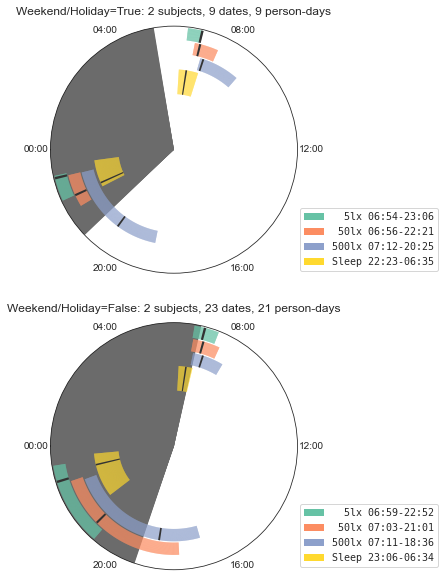

In [ ]:
ClockPlot.plot(data,
               'Weekend/Holiday',
               thresholds = [5, 50, 500],
               timezone = "America/Los_Angeles")

#### things to remember to talk about

1. thresholds --> should be present in the data
2. how to read the plot (bars are ranges of values, black line is median)